In [1]:
import numpy as truenp

import matplotlib.pyplot as plt
import matplotlib.cm as color
better_magma = color.magma
better_magma.set_bad('black',1.)
import matplotlib.colors as c

from prysm import (
    mathops, 
    conf,
)
from prysm.mathops import (
    np,
    fft,
    interpolate,
    ndimage,
)
from prysm.coordinates import (
    make_xy_grid, 
    cart_to_polar,
)
from prysm.propagation import Wavefront as WF
from prysm.propagation import (
    focus_fixed_sampling,
    focus_fixed_sampling_backprop
)                              
from prysm.thinlens import (
    defocus_to_image_displacement,
    image_displacement_to_defocus,
)
from prysm.geometry import (
    circle,
    spider,
)
from prysm.polynomials import (
    lstsq,
    noll_to_nm,
    zernike_nm,
    zernike_nm_seq,
    hopkins,
    sum_of_2d_modes,
    sum_of_2d_modes_backprop
)
mathops.set_backend_to_cupy()
# conf.config.precision = 32

from astropy.io import (
    fits,
    ascii,
)

from skimage.measure import centroid

import copy

from lina.phase_retrieval import ADPR, FDPR, BBPR
from lina.utils import TikhonovInverse

import config_um
import config_um_wcc
from Batoid4LOFT.LAZULI_STOP import Lazuli_stop, readBulkMotion, readDeformation

from psd_utils import PSDUtils

from scipy.optimize import minimize

from scipy.interpolate import RegularGridInterpolator

from tqdm import tqdm

from psd_utils import PSDUtils

from model import off_axis_3m_TMA
from algos import FFPR
import utils

# logging stuff
import logging
psd_log = logging.getLogger('__psd_utils__')
psd_log.disabled = True

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# init model

In [2]:
cfg_um = config_um.load_config_values('unitless')
cfg_um_wcc = config_um_wcc.load_config_values('unitless')

path_um = config_um.get_data_path()
path_um_wcc = config_um_wcc.get_data_path() + '/'

In [3]:
opd_maps = utils.load_pickle('/home/derbyk/src/ffpr/data/opd_maps.pkl')

In [4]:
detector_data = utils.load_pickle('/home/derbyk/src/ffpr/data/detector_data.pkl')

In [5]:
platescale = 4.905 # arcsec/mm

w = 36 * platescale / 60
h = 24 * platescale / 60
w_offset = w / 2
h_offset = h / 2

positions = [(data['xy'][0] + w_offset, data['xy'][1] + h_offset) for data in detector_data]
defocuses = [float(data['defocus']) for data in detector_data]

In [6]:
sys = off_axis_3m_TMA(opd_maps=opd_maps, config_stp=cfg_um, config_wcc=cfg_um_wcc,
                      data_path_stp=path_um, data_path_wcc=path_um_wcc, use_raytrace=False)

# lots n lots o stars
mags = (np.ones(len(positions)) * 15).tolist()
# positions = [(-6,  3), (0,  3), (6,  3),
#              (-12,  0), (0,  0), (12,  0),
#              (-12, -3), (0, -3), (12, -3),]
# defocuses = [1., -1.,  1.,
#               -1.,   0.,   -1.,
#              1.,  -1., 1.]
sys.set_source_parameters(magnitudes=mags, positions=positions, defocus_vals=defocuses)

sys.set_m1_bending(-np.sum(np.array(sys.get_opds()['Optics']), axis=0))

images = sys.snap(stacked_frames=25)

imnorm = images[1].max()

print(imnorm)

13352.8


In [7]:
sys = off_axis_3m_TMA(opd_maps=opd_maps, config_stp=cfg_um, config_wcc=cfg_um_wcc,
                      data_path_stp=path_um, data_path_wcc=path_um_wcc)

# lots n lots o stars
mags = (np.ones(len(positions)) * 15).tolist()
# positions = [(-6,  3), (0,  3), (6,  3),
#              (-12,  0), (0,  0), (12,  0),
#              (-12, -3), (0, -3), (12, -3),]
# defocuses = [1., -1.,  1.,
#               -1.,   0.,   -1.,
#              1.,  -1., 1.]
sys.set_source_parameters(magnitudes=mags, positions=positions, defocus_vals=defocuses)

images = sys.snap(stacked_frames=25)

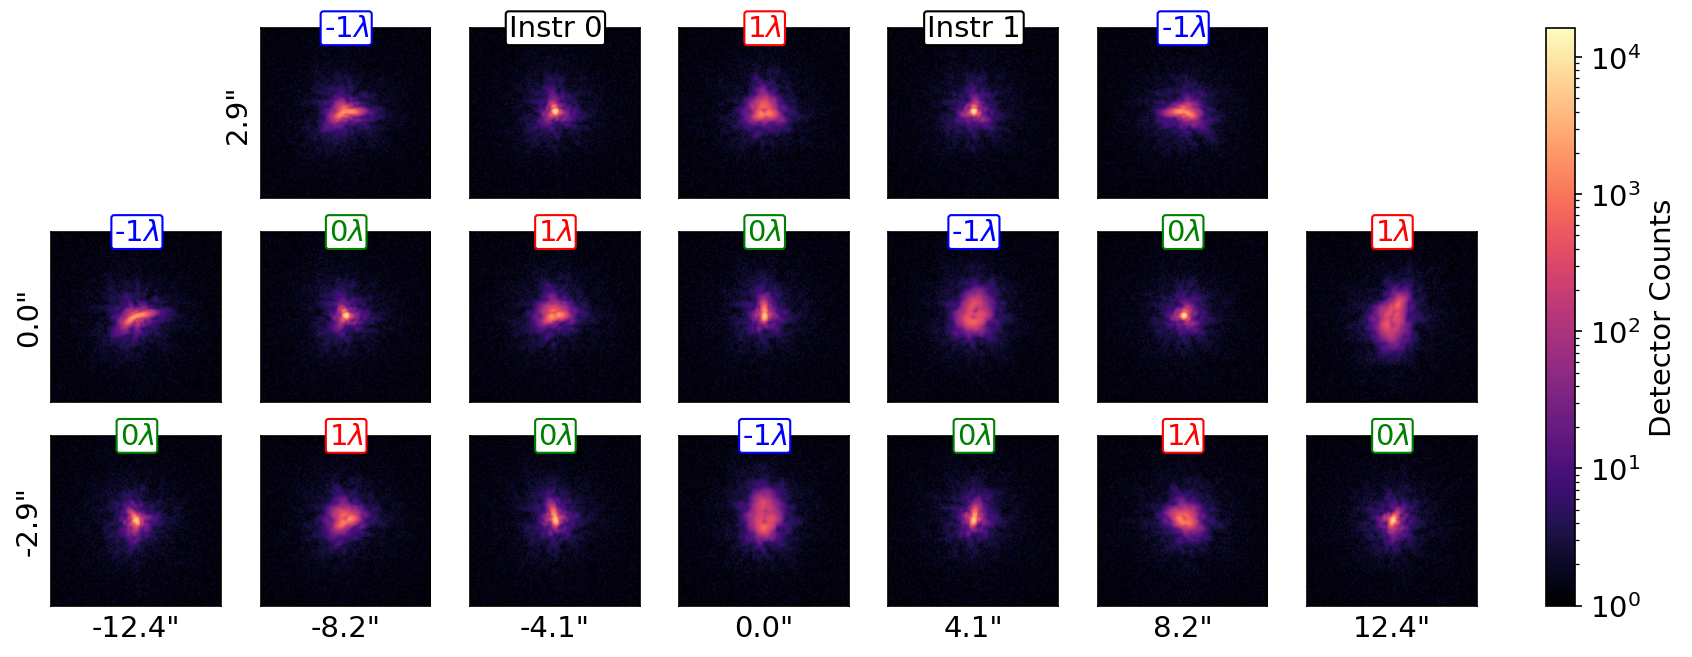

In [8]:
fig, axs = plt.subplots(ncols=7, nrows=3, figsize=(15, 5), dpi=150)
spec = plt.GridSpec(ncols=7, nrows=3)

count = 0
lol = 0
for i, ax in enumerate(axs.flat):
    if  i == 0 or i == 6:
        ax.axis('off')
    else:
        im = ax.imshow(images[count].get(), cmap='magma', norm='log', vmax=sys.well_depth, vmin=1)
        ax.set_xticks([])
        ax.set_yticks([])

        if count in (0, 5, 12):
            ax.set_ylabel(f'{sys.src_pos[count][1] * 60:.01f}"', fontsize=14)
        
        if count >= 12:
            ax.set_xlabel(f'{sys.src_pos[count][0] * 60:.01f}"', fontsize=14)

        if defocuses[count] == -1:
            c = "blue"
        elif defocuses[count] == 0:
            c = "green"
        elif defocuses[count] == 1:
            c = "red"
        l = f'{defocuses[count]:.0f}$\lambda$'

        if count in (1, 3):
            c = "black"
            l = f"Instr {lol:.0f}"
            lol += 1

        ax.text(64, 138, l,
                color=c, fontsize=14,
                ha='center', va='top',
                bbox=dict(facecolor='white', edgecolor=c, alpha=1, pad=0.1, boxstyle='round'))
        
        count += 1


cb = plt.colorbar(im, ax=axs, fraction=0.14, pad=0.04, label='Detector Counts')
cb.set_label('Detector Counts', fontsize=14)
cb.ax.tick_params(labelsize=14)
fig.set_tight_layout = True


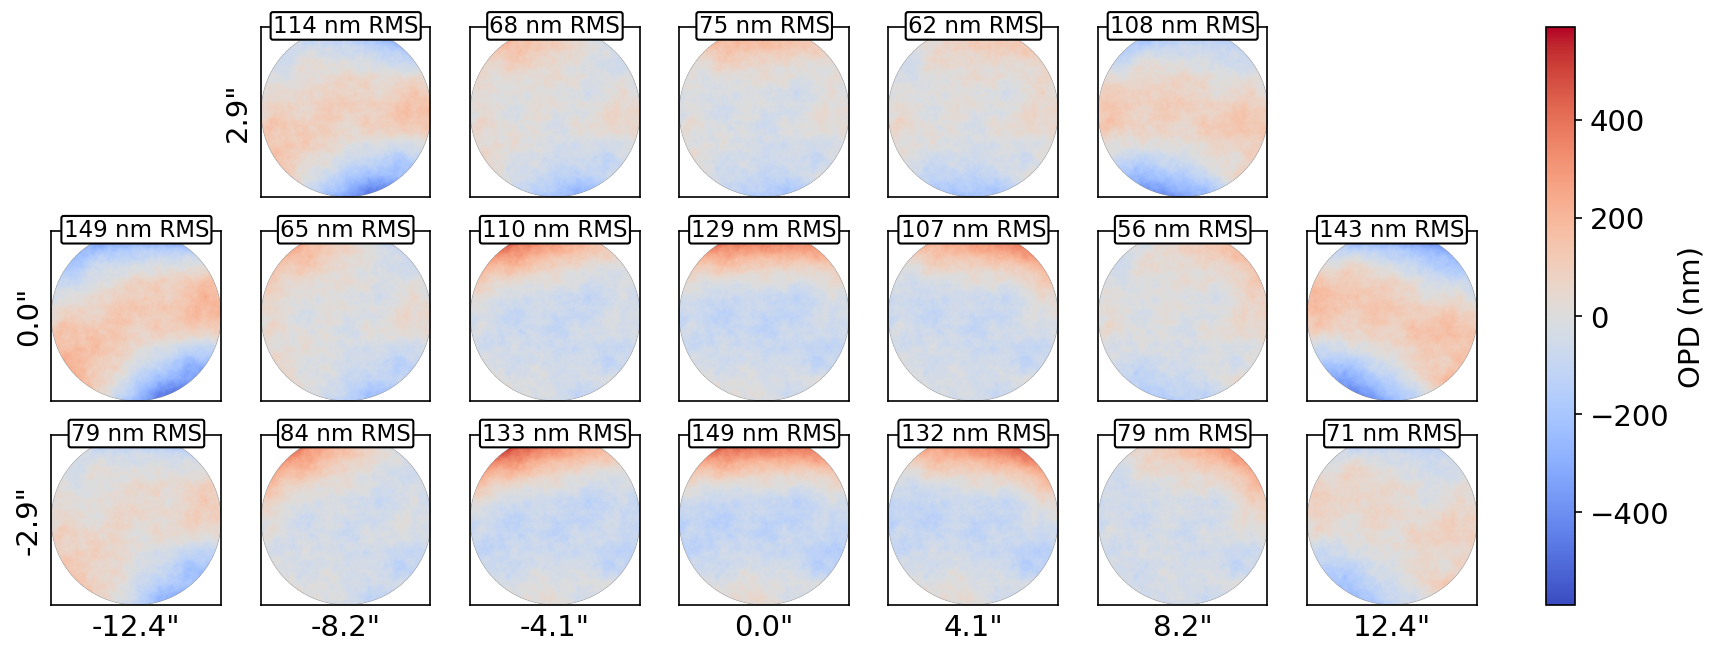

In [9]:
opds = sys.get_opds()['Field']

optic_opd = np.sum(np.array(sys.get_opds()['Optics']), axis=0)

rms_vals = []
for opd in opds:
    opd[~sys.pupil] = np.nan
    opd -= np.nanmean(opd)

v1 = np.nanmax(np.array(opds))
v2 = np.abs(np.nanmin(np.array(opds)))
v = np.max(np.array([v1, v2]))

opds = [opd + optic_opd for opd in opds]

for opd in opds:
    opd[~sys.pupil] = np.nan
    opd -= np.nanmean(opd)
    rms_vals.append(np.sqrt(np.nanmean(opd ** 2)))

fig, axs = plt.subplots(ncols=7, nrows=3, figsize=(15, 5), dpi=150)
spec = plt.GridSpec(ncols=7, nrows=3)

count = 0
for i, ax in enumerate(axs.flat):
    if  i == 0 or i == 6:
        ax.axis('off')
    else:
        im = ax.imshow(opds[count].get(), cmap='coolwarm', vmax=v, vmin=-v)
        ax.set_xticks([])
        ax.set_yticks([])

        if count in (0, 5, 12):
            ax.set_ylabel(f'{sys.src_pos[count][1] * 60:.01f}"', fontsize=14)
        
        if count >= 12:
            ax.set_xlabel(f'{sys.src_pos[count][0] * 60:.01f}"', fontsize=14)

        l = f'{rms_vals[count]:.0f} nm RMS'
        c = "black"

        ax.text(256, 550, l,
                color=c, fontsize=11,
                ha='center', va='top',
                bbox=dict(facecolor='white', edgecolor=c, alpha=1, pad=0.1, boxstyle='round'))
        
        count += 1


cb = plt.colorbar(im, ax=axs, fraction=0.14, pad=0.04)
cb.set_label('OPD (nm)', fontsize=14)
cb.ax.tick_params(labelsize=14)
fig.set_tight_layout = True

Text(0.5, 1.0, 'M1 - M4 Optic Surface Errors\n27.20 nm RMS')

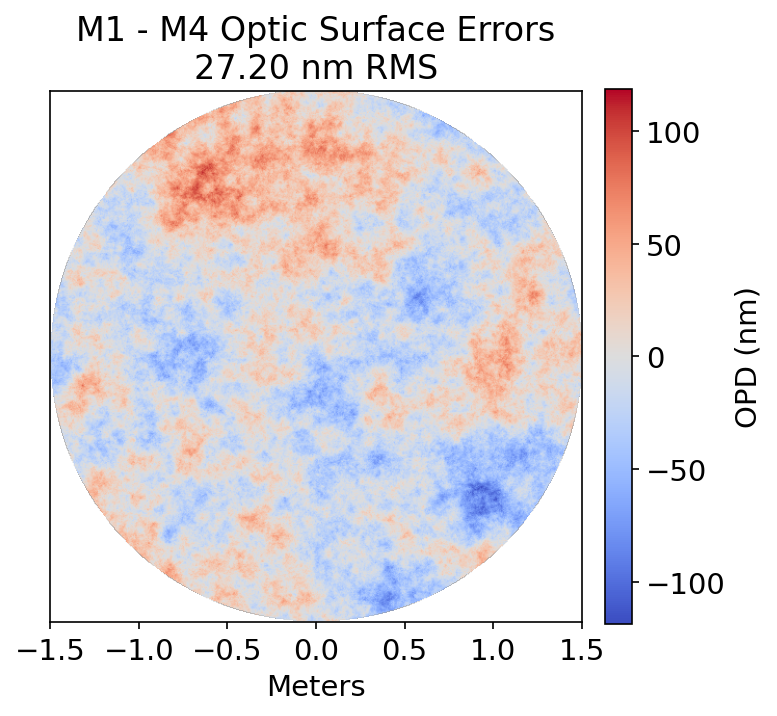

In [10]:
optic_opd[~sys.pupil] = np.nan

v1 = np.nanmax(optic_opd)
v2 = np.abs(np.nanmin(optic_opd))
v = np.max(np.array([v1, v2]))

plt.figure(figsize=(5, 5), dpi=150)
im = plt.imshow(optic_opd.get(), cmap='coolwarm', vmin=-v, vmax=v, extent=[-1.5, 1.5, -1.5, 1.5])
cb = plt.colorbar(im, fraction=0.046, pad=0.04)
cb.set_label('OPD (nm)', fontsize=14)
cb.ax.tick_params(labelsize=14)
plt.xlabel('Meters', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks([])
plt.title(f'M1 - M4 Optic Surface Errors\n{np.sqrt(np.nanmean(optic_opd[sys.pupil] ** 2)):.2f} nm RMS', fontsize=16)

# field stuff

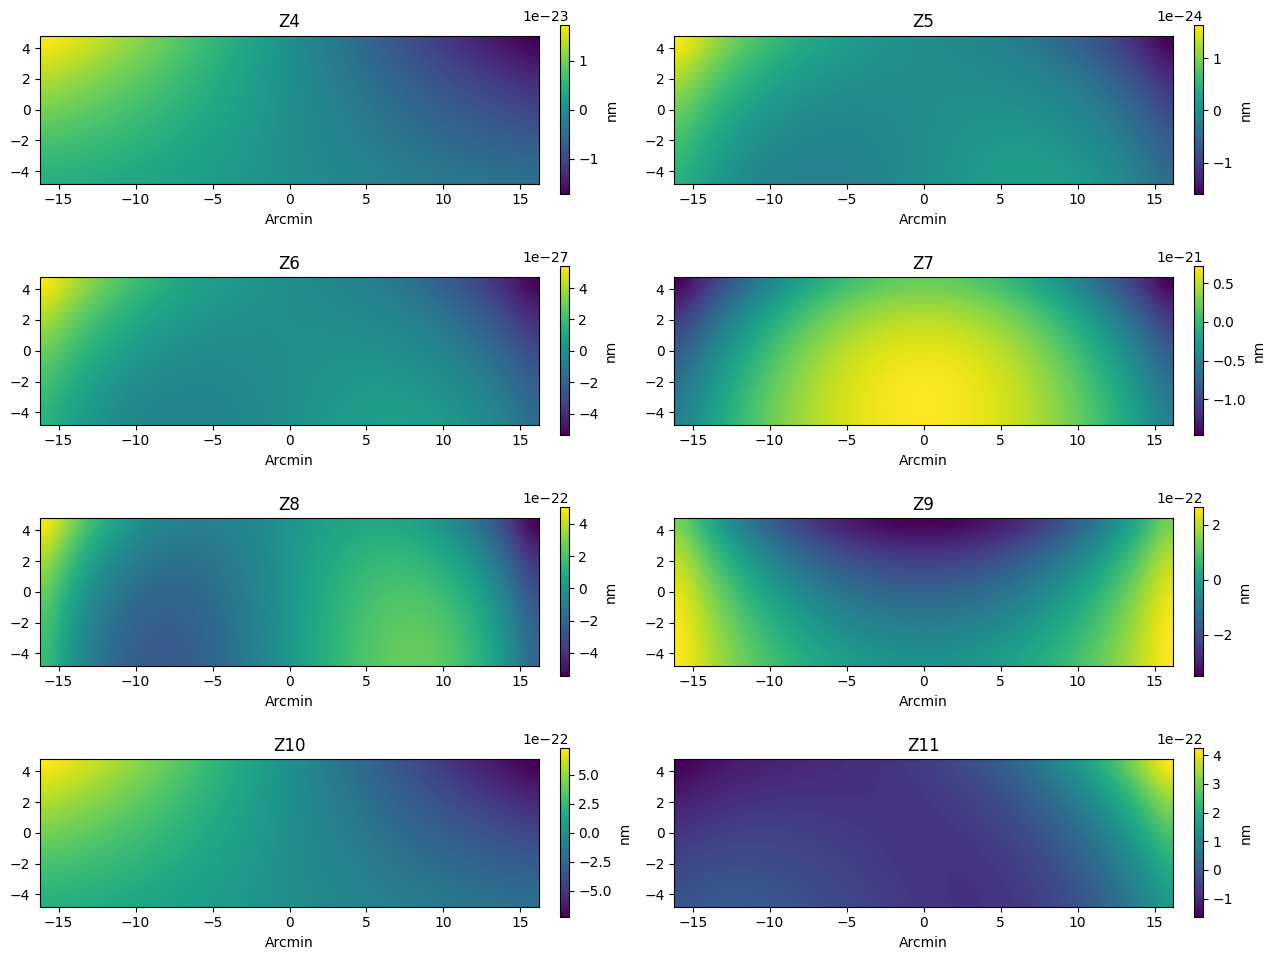

In [ ]:
raytrace = Lazuli_stop()

# zernike basis (excluding piston) up to Z37
x, y = make_xy_grid(sys.pupil.shape[0], dx=sys.dx_pup)
r, t = cart_to_polar(x, y)
nms = [noll_to_nm(i) for i in range(2, 37)]
zernikes = list(zernike_nm_seq(nms, r, t, norm=True))
# zernikes = [z / np.max(np.abs(z)) for z in zernikes]

# indices for the zernikes which exhibit field dependence that changes with alignment: defocus, coma, astig, trefoil, spherical
# THESE DO NOT CORRESPOND TO NOLL INDICES
inds = [i + 2 for i in range(8)]

# field positions to evaluate
fields_x = np.linspace(-16.2, 16.2, 33) / 60 # +/- 16.2 arcmin in x
fields_y = np.linspace(-4.8, 4.8, 11) / 60  # +/- 4.8 arcmin in y

# initialize array to hold coeffs for field-dependent zernikes at nominal alignment
field_coeffs_nom = np.zeros((len(inds), len(fields_x), len(fields_y)))

# loop through fields
for i, field_x in enumerate(fields_x):
    for j, field_y in enumerate(fields_y):
        
        # get raytrace OPD at field point
        ray_data = raytrace.get_OPD(fieldX=field_x.get(), fieldY=field_y.get(), npx=sys.pupil.shape[0])
        opd = np.array(ray_data['wavefront'].array.data * ~ray_data['wavefront'].array.mask) * sys.wvl0 * 1e3
        opd[~sys.pupil] = np.nan

        # decompose
        field_coeffs_nom[:, i, j] = lstsq(np.array(zernikes), opd)[inds]

# create interpolators for field-dependent zernikes
field_interps_nom = [interpolate.RegularGridInterpolator((fields_x, fields_y), field_coeffs_nom[i, :, :], method='cubic') for i in range(field_coeffs_nom.shape[0])]

# show field dependence for field-dependent zernikes
plt.figure(figsize=(15, 12))
for i in range(field_coeffs_nom.shape[0]):
    plt.subplot(4, 2, i + 1)
    plt.title(f'Z{i + 4:.0f}')
    plt.imshow(field_coeffs_nom[i, :, :].get().T, interpolation='bicubic', extent=[-16.2, 16.2, -4.8, 4.8])
    plt.xlabel('Arcmin')
    plt.colorbar(fraction=0.016, pad=0.04, label='nm')

# m2 calibration

In [12]:
# calibration amplitudes for M2
amp_d = 10e-6        # decenters
amp_t = 1e-6        # tilts 

# M2 degrees of freedom to calibrate
dofs = ['M1_dx', 'M1_dy', 'M1_dz', 'M1_tx', 'M1_ty',
        'M2_dx', 'M2_dy', 'M2_dz', 'M2_tx', 'M2_ty']

jac_m2 = np.zeros((len(dofs), len(inds) * len(sys.field_aber)))

# calibration loop
for i, dof in enumerate(dofs):
    M1_motion = {'user_motion' : {'x' : 0, 'y' : 0, 'z' : 0, 'tip' : 0, 'tilt' : 0}}
    M2_motion = {'user_motion' : {'x' : 0, 'y' : 0, 'z' : 0, 'tip' : 0, 'tilt' : 0}}

    if dof.__contains__('d'):
        amps = [-amp_d, amp_d]
    elif dof.__contains__('t'):
        amps = [-amp_t, amp_t]

    for amp in amps:

        # I fucking hate you pierre
        if dof == 'M1_dx':
            M1_motion['user_motion']['x'] += amp
            sys.move_optics(M1_motion=M1_motion, M2_motion=M2_motion)
        if dof == 'M1_dy':
            M1_motion['user_motion']['y'] += amp
            sys.move_optics(M1_motion=M1_motion, M2_motion=M2_motion)
        if dof == 'M1_dz':
            M1_motion['user_motion']['z'] += amp
            sys.move_optics(M1_motion=M1_motion, M2_motion=M2_motion)
        if dof == 'M1_tx':
            M1_motion['user_motion']['tip'] += amp
            sys.move_optics(M1_motion=M1_motion, M2_motion=M2_motion)
        if dof == 'M1_ty':
            M1_motion['user_motion']['tilt'] += amp
            sys.move_optics(M1_motion=M1_motion, M2_motion=M2_motion)

        if dof == 'M2_dx':
            M2_motion['user_motion']['x'] += amp
            sys.move_optics(M1_motion=M1_motion, M2_motion=M2_motion)
        if dof == 'M2_dy':
            M2_motion['user_motion']['y'] += amp
            sys.move_optics(M1_motion=M1_motion, M2_motion=M2_motion)
        if dof == 'M2_dz':
            M2_motion['user_motion']['z'] += amp
            sys.move_optics(M1_motion=M1_motion, M2_motion=M2_motion)
        if dof == 'M2_tx':
            M2_motion['user_motion']['tip'] += amp
            sys.move_optics(M1_motion=M1_motion, M2_motion=M2_motion)
        if dof == 'M2_ty':
            M2_motion['user_motion']['tilt'] += amp
            sys.move_optics(M1_motion=M1_motion, M2_motion=M2_motion)

        opds = sys.get_opds()['Field']

        for j, opd in enumerate(opds):
            opd[~sys.pupil] = np.nan
            coeffs = lstsq(np.array(zernikes), opd)[inds]
        
            jac_m2[i, j * len(inds):j * len(inds) + len(inds)] += coeffs * amp / (2 * np.var(np.array(amps)))

# test m2 loop

{'user_motion': {'x': -2.2087436020694738e-06, 'y': 3.5435298931696496e-06, 'z': -1.7864666447197237e-07, 'tip': -7.078523286548343e-07, 'tilt': -2.4322790805872693e-07}}
{'user_motion': {'x': -1.8348491562894644e-06, 'y': 4.9340469738311336e-08, 'z': -9.378174504127738e-08, 'tip': -1.8182782495478097e-07, 'tilt': -5.718276759587656e-07}}


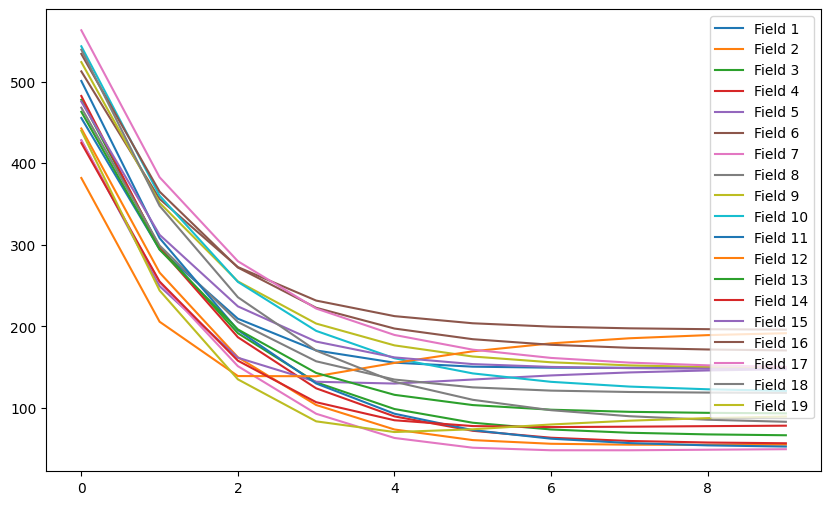

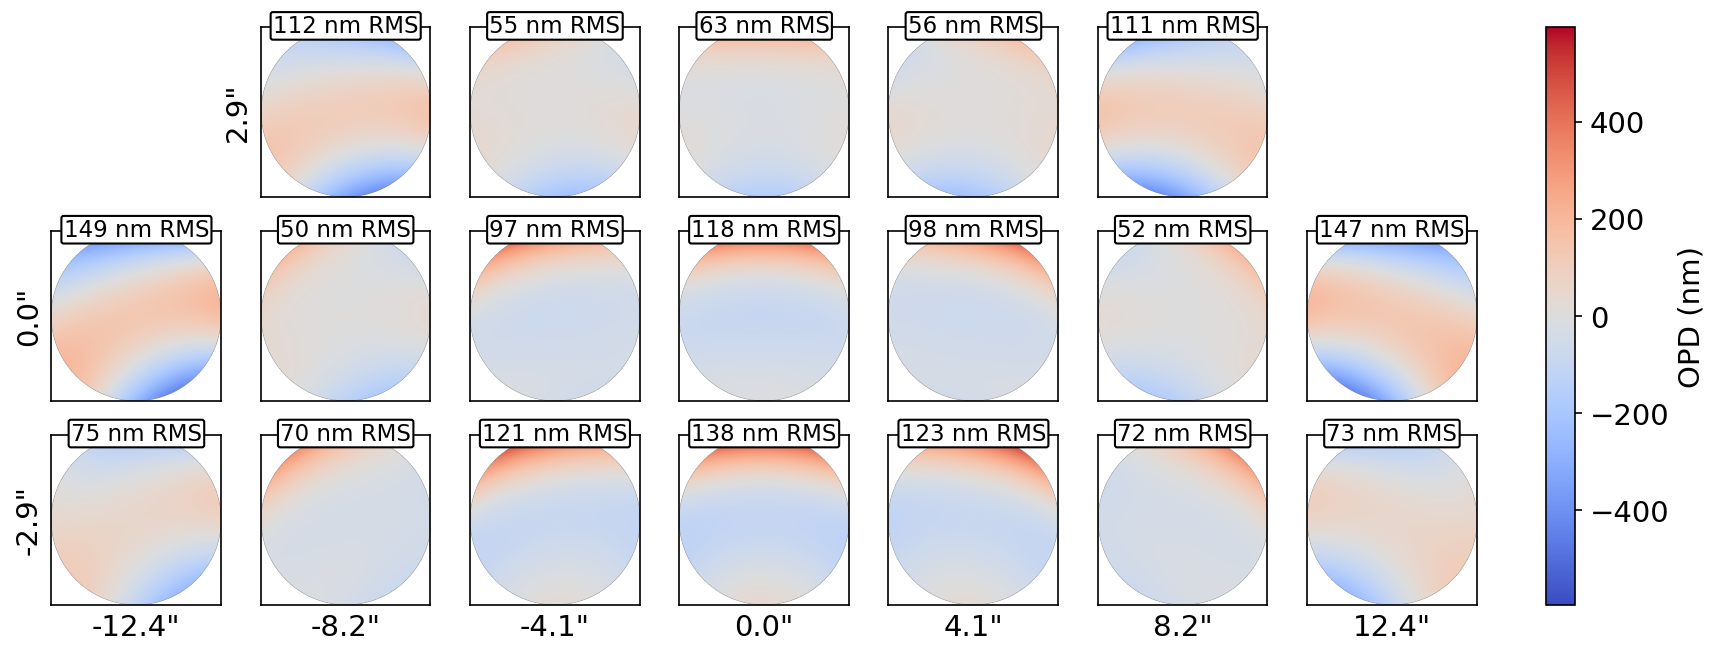

In [13]:
iterations = 10
gain = 0.2

control_m2 = TikhonovInverse(jac_m2, rcond=1e-4)

M1_motion = {'user_motion' : {'x' : -286e-6, 'y' : 67e-6, 'z' : -162e-6, 'tip' : 6e-6, 'tilt' : -21e-6}}
M2_motion = {'user_motion' : {'x' : -311e-6, 'y' : 44e-6, 'z' : -139e-6, 'tip' : 73e-6, 'tilt' : -81e-6}}
sys.move_optics(M1_motion=M1_motion, M2_motion=M2_motion)

rms_vals = np.zeros((len(sys.field_aber), iterations))

nominal_coeffs = np.array([[interp(np.array(position)) for interp in field_interps_nom] for position in sys.src_pos])

for i in range(iterations):

    print('iteration ' + str(i + 1), end='\r')

    field_coeffs = np.zeros((len(inds) * len(sys.field_aber)))

    opds = sys.get_opds()['Field']

    for j, opd in enumerate(opds):
        opd[~sys.pupil] = np.nan
        coeffs = lstsq(np.array(zernikes), opd)[inds] - np.squeeze(nominal_coeffs[j, :])

        field_coeffs[j * len(inds):j * len(inds) + len(inds)] = coeffs

        rms_vals[j, i] = np.sqrt(np.mean(opd[sys.pupil] ** 2))

    command = np.matmul(control_m2.T, field_coeffs).get()

    M1_motion['user_motion']['x'] -= command[0] * gain
    M1_motion['user_motion']['y'] -= command[1] * gain
    M1_motion['user_motion']['z'] -= command[2] * gain
    M1_motion['user_motion']['tip'] -= command[3] * gain
    M1_motion['user_motion']['tilt'] -= command[4] * gain
    M2_motion['user_motion']['x'] -= command[5] * gain
    M2_motion['user_motion']['y'] -= command[6] * gain
    M2_motion['user_motion']['z'] -= command[7] * gain
    M2_motion['user_motion']['tip'] -= command[8] * gain
    M2_motion['user_motion']['tilt'] -= command[9] * gain

    # M2_motion['user_motion']['x'] -= command[0] * gain
    # M2_motion['user_motion']['y'] -= command[1] * gain
    # M2_motion['user_motion']['z'] -= command[2] * gain
    # M2_motion['user_motion']['tip'] -= command[3] * gain
    # M2_motion['user_motion']['tilt'] -= command[4] * gain

    sys.move_optics(M1_motion=M1_motion, M2_motion=M2_motion)


print(M1_motion)
print(M2_motion)

plt.figure(figsize=(10, 6))
for i in range(len(sys.field_aber)):
    plt.plot(rms_vals[i, :].get(), label='Field ' + str(i + 1))
plt.legend()

opds = sys.get_opds()['Field']

rms_vals = []
for opd in opds:
    opd[~sys.pupil] = np.nan
    opd -= np.nanmean(opd)
    rms_vals.append(np.sqrt(np.nanmean(opd ** 2)))

v1 = np.nanmax(np.array(opds))
v2 = np.abs(np.nanmin(np.array(opds)))
v = np.max(np.array([v1, v2]))
fig, axs = plt.subplots(ncols=7, nrows=3, figsize=(15, 5), dpi=150)
spec = plt.GridSpec(ncols=7, nrows=3)

count = 0
for i, ax in enumerate(axs.flat):
    if  i == 0 or i == 6:
        ax.axis('off')
    else:
        im = ax.imshow(opds[count].get(), cmap='coolwarm', vmax=v, vmin=-v)
        ax.set_xticks([])
        ax.set_yticks([])

        if count in (0, 5, 12):
            ax.set_ylabel(f'{sys.src_pos[count][1] * 60:.01f}"', fontsize=14)
        
        if count >= 12:
            ax.set_xlabel(f'{sys.src_pos[count][0] * 60:.01f}"', fontsize=14)

        l = f'{rms_vals[count]:.0f} nm RMS'
        c = "black"

        ax.text(256, 550, l,
                color=c, fontsize=11,
                ha='center', va='top',
                bbox=dict(facecolor='white', edgecolor=c, alpha=1, pad=0.1, boxstyle='round'))
        
        count += 1


cb = plt.colorbar(im, ax=axs, fraction=0.14, pad=0.04)
cb.set_label('OPD (nm)', fontsize=14)
cb.ax.tick_params(labelsize=14)
fig.set_tight_layout = True

# misalign system

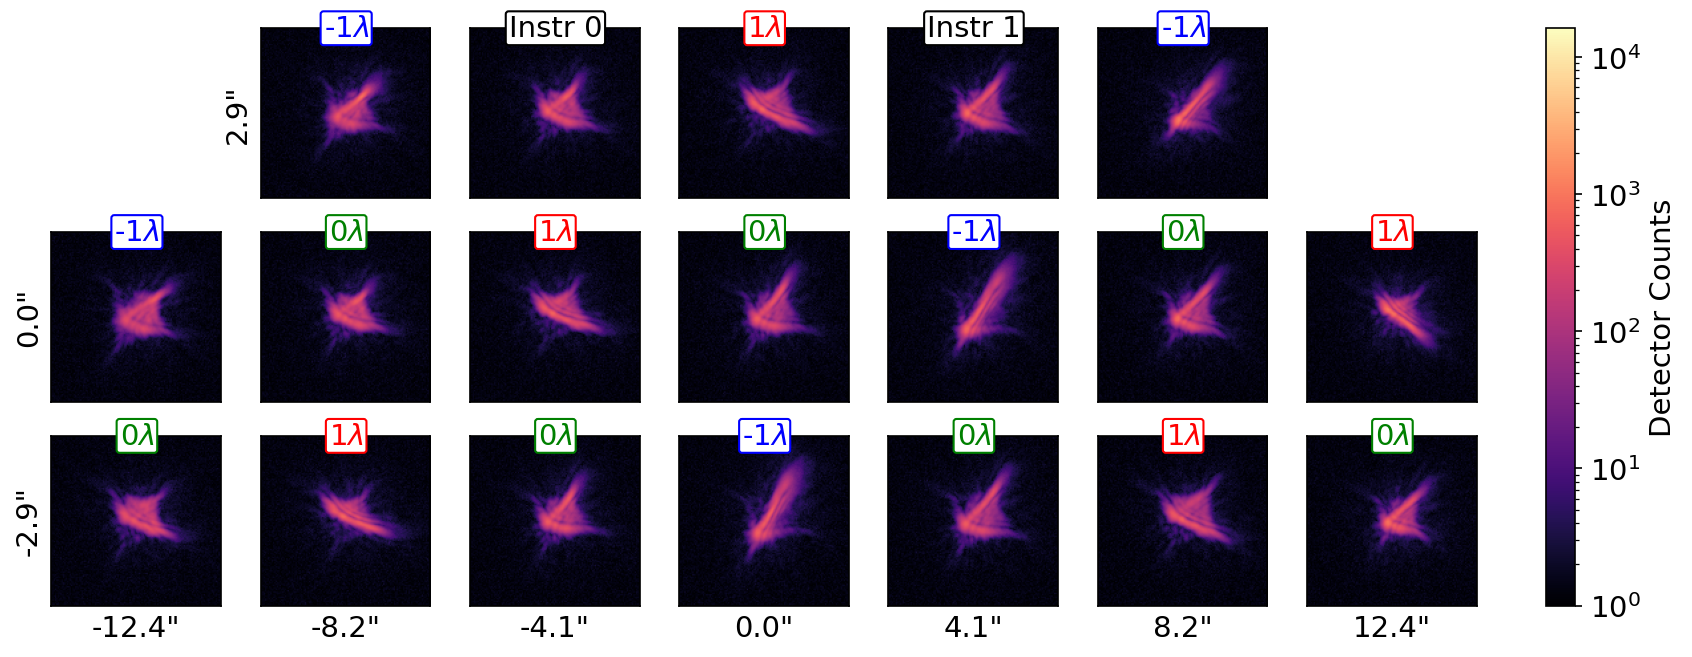

In [41]:
# M1_motion = {'user_motion' : {'x' : -286e-6, 'y' : 67e-6, 'z' : -162e-6, 'tip' : 2.6e-6, 'tilt' : -3.1e-6}}
# M2_motion = {'user_motion' : {'x' : -311e-6, 'y' : 44e-6, 'z' : -139e-6, 'tip' : 7.3e-6, 'tilt' : -20e-6}}
M1_motion = {'user_motion' : {'x' : -286e-6, 'y' : 67e-6, 'z' : -162e-6, 'tip' : 6e-6, 'tilt' : -21e-6}}
M2_motion = {'user_motion' : {'x' : -311e-6, 'y' : 44e-6, 'z' : -139e-6, 'tip' : 73e-6, 'tilt' : -81e-6}}
M3_motion = {'user_motion' : {'x' : 0, 'y' : 0, 'z' : 0, 'tip' : 0, 'tilt' : 0}}
M4_motion = {'user_motion' : {'x' : 0, 'y' : 0, 'z' : 0, 'tip' : 0, 'tilt' : 0}}

sys.move_optics(M1_motion=M1_motion, M2_motion=M2_motion, M3_motion=M3_motion, M4_motion=M4_motion)

sys.set_m1_bending(np.zeros((sys.npix, sys.npix)))

images = sys.snap(stacked_frames=30)

fig, axs = plt.subplots(ncols=7, nrows=3, figsize=(15, 5), dpi=150)
spec = plt.GridSpec(ncols=7, nrows=3)

count = 0
lol = 0
for i, ax in enumerate(axs.flat):
    if  i == 0 or i == 6:
        ax.axis('off')
    else:
        im = ax.imshow(images[count].get(), cmap='magma', norm='log', vmax=sys.well_depth, vmin=1)
        ax.set_xticks([])
        ax.set_yticks([])

        if count in (0, 5, 12):
            ax.set_ylabel(f'{sys.src_pos[count][1] * 60:.01f}"', fontsize=14)
        
        if count >= 12:
            ax.set_xlabel(f'{sys.src_pos[count][0] * 60:.01f}"', fontsize=14)

        if defocuses[count] == -1:
            c = "blue"
        elif defocuses[count] == 0:
            c = "green"
        elif defocuses[count] == 1:
            c = "red"
        l = f'{defocuses[count]:.0f}$\lambda$'

        if count in (1, 3):
            c = "black"
            l = f"Instr {lol:.0f}"
            lol += 1

        ax.text(64, 138, l,
                color=c, fontsize=14,
                ha='center', va='top',
                bbox=dict(facecolor='white', edgecolor=c, alpha=1, pad=0.1, boxstyle='round'))
        
        count += 1


cb = plt.colorbar(im, ax=axs, fraction=0.14, pad=0.04, label='Detector Counts')
cb.set_label('Detector Counts', fontsize=14)
cb.ax.tick_params(labelsize=14)
fig.set_tight_layout = True


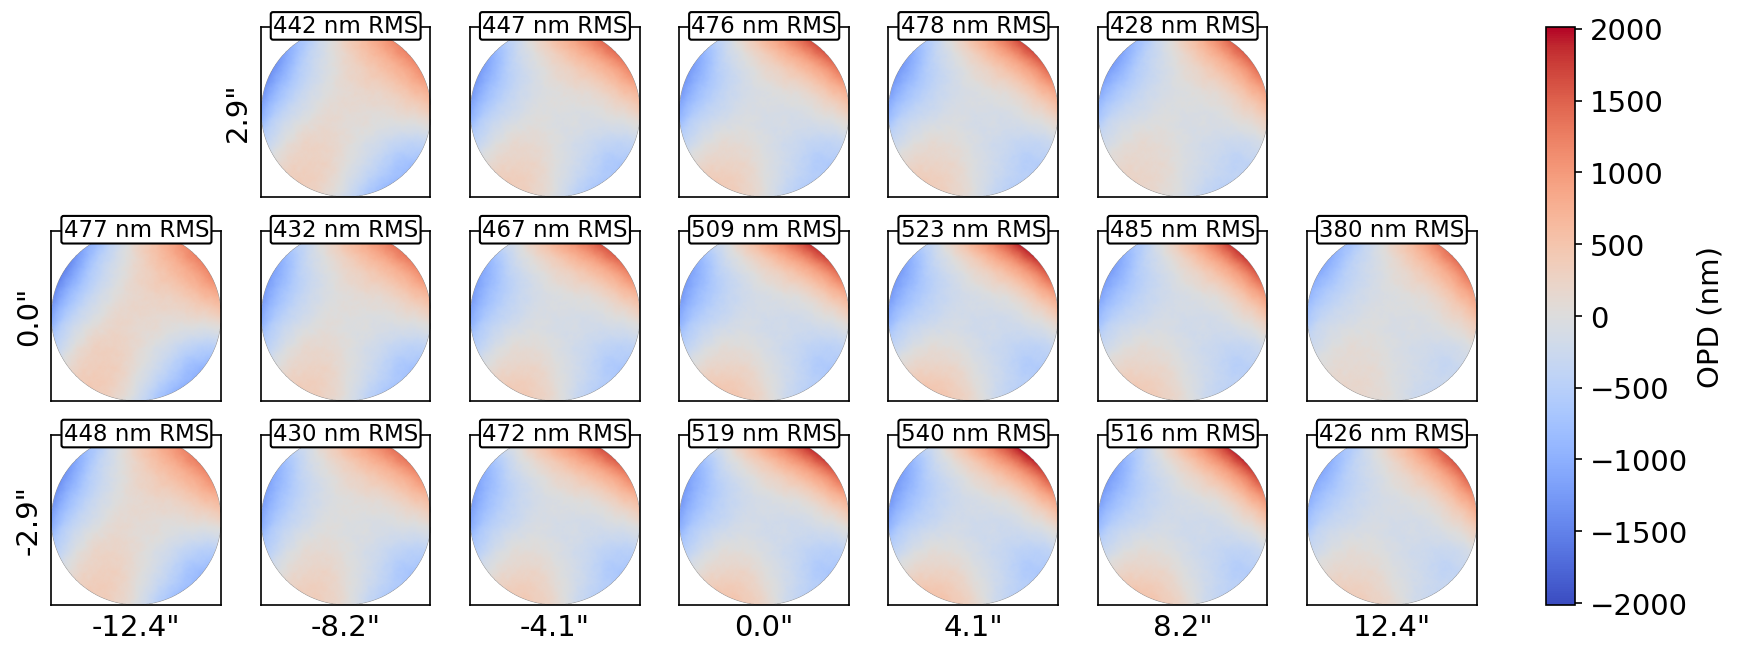

In [42]:
opds = sys.get_opds()['Field']

optic_opd = np.sum(np.array(sys.get_opds()['Optics']), axis=0) + sys.get_opds()['Bending']

rms_vals = []
for opd in opds:
    opd[~sys.pupil] = np.nan
    opd -= np.nanmean(opd)

v1 = np.nanmax(np.array(opds))
v2 = np.abs(np.nanmin(np.array(opds)))
v = np.max(np.array([v1, v2]))

opds = [opd + optic_opd for opd in opds]

for opd in opds:
    opd[~sys.pupil] = np.nan
    opd -= np.nanmean(opd)
    rms_vals.append(np.sqrt(np.nanmean(opd ** 2)))

fig, axs = plt.subplots(ncols=7, nrows=3, figsize=(15, 5), dpi=150)
spec = plt.GridSpec(ncols=7, nrows=3)

count = 0
for i, ax in enumerate(axs.flat):
    if  i == 0 or i == 6:
        ax.axis('off')
    else:
        im = ax.imshow(opds[count].get(), cmap='coolwarm', vmax=v, vmin=-v)
        ax.set_xticks([])
        ax.set_yticks([])

        if count in (0, 5, 12):
            ax.set_ylabel(f'{sys.src_pos[count][1] * 60:.01f}"', fontsize=14)
        
        if count >= 12:
            ax.set_xlabel(f'{sys.src_pos[count][0] * 60:.01f}"', fontsize=14)

        l = f'{rms_vals[count]:.0f} nm RMS'
        c = "black"

        ax.text(256, 550, l,
                color=c, fontsize=11,
                ha='center', va='top',
                bbox=dict(facecolor='white', edgecolor=c, alpha=1, pad=0.1, boxstyle='round'))
        
        count += 1


cb = plt.colorbar(im, ax=axs, fraction=0.14, pad=0.04)
cb.set_label('OPD (nm)', fontsize=14)
cb.ax.tick_params(labelsize=14)
fig.set_tight_layout = True

# closed loop ffpr

In [43]:
alignment_ims = []
alignment_opds = []
alignment_rms = []

gain_m1 = 0.1
gain_m2 = 0.25
control_m2 = TikhonovInverse(jac_m2, rcond=1e-2)

iterations = 15

bending = np.zeros((sys.npix, sys.npix))

In [44]:
for iter in range(iterations):
    print('iteration ' + str(iter + 1), end='\r')
    images = sys.snap(stacked_frames=30) 
    alignment_ims.append([utils.ensure_np(im) for im in images])

    opds = sys.get_opds()['Field']
    optic_opd = np.sum(np.array(sys.get_opds()['Optics']), axis=0) + sys.get_opds()['Bending']
    opds = [opd + optic_opd for opd in opds]

    rms_vals = []
    for opd in opds:
        opd[~sys.pupil] = np.nan
        opd -= np.nanmean(opd)
        rms_vals.append(np.sqrt(np.nanmean(opd ** 2)))

    alignment_opds.append([utils.ensure_np(opd) for opd in opds])
    alignment_rms.append(rms_vals)

    adpr_list = []
    for psf, defocus in zip(images, defocuses):
        adpr_list.append(ADPR(wvls=sys.wvls.tolist(), pupil=sys.pupil, dx_pupil=sys.dx_pup, psf=psf, dx_psf=sys.dx_detector,
                            efl=sys.efl, modes=zernikes, defocus_coeff=defocus))

    ff_opt = FFPR(optlist=adpr_list, psf_positions=sys.src_pos, field_modes=zernikes[2:10], field_coeff_interps=field_interps_nom)
    ff_opt.minimize_field(jac=True, method='L-BFGS-B', options={'maxls' : 10, 'ftol' : 1e-20, 'gtol' : 1e-8, 'disp' : 0, 'maxiter' : 20})
    ff_opt.minimize_common(jac=True, method='L-BFGS-B', options={'maxls' : 10, 'ftol' : 1e-20, 'gtol' : 1e-6, 'disp' : 0, 'maxiter' : 20})
    ff_opt.minimize_field(jac=True, method='L-BFGS-B', options={'maxls' : 10, 'ftol' : 1e-20, 'gtol' : 1e-8, 'disp' : 0, 'maxiter' : 20})
    ff_opt.minimize_common(jac=True, method='L-BFGS-B', options={'maxls' : 10, 'ftol' : 1e-20, 'gtol' : 1e-6, 'disp' : 0, 'maxiter' : 20})


    # plt.figure(figsize=(14, 8), dpi=150)
    # plt.title('FFPR Optimization', fontsize=16)
    # for i, opt in enumerate(ff_opt.optlist):
    #     plt.semilogy(np.array(opt.costs).get(), label=f'({sys.src_pos[i][0] * 60:.1f}", {sys.src_pos[i][1] * 60:.1f}")', alpha=0.5, linewidth=1)
    # plt.semilogy(np.array(ff_opt.costs).get(), label='Mean', color='k', linewidth=1)
    # plt.xlabel('L-BFGS-B Iteration', fontsize=14)
    # plt.ylabel('Error Function', fontsize=14)
    # plt.legend(ncol=3, fontsize=14)
    # plt.xlim([0, len(ff_opt.costs)])
    # plt.ylim([0, 1])
    # plt.grid(alpha=0.4, which='both')
    # plt.xticks(fontsize=14)
    # plt.yticks(fontsize=14)

    if iter <= 10:
        nominal_coeffs = np.array([[interp(np.array(position)) for interp in field_interps_nom] for position in sys.src_pos])

        field_coeffs = np.zeros((len(inds) * len(sys.field_aber)))

        opds = [opt.opd for opt in ff_opt.optlist]

        for j, opd in enumerate(opds):
            opd[~sys.pupil] = np.nan
            coeffs = lstsq(np.array(zernikes), opd)[inds] - np.squeeze(nominal_coeffs[j, :]) + lstsq(np.array(zernikes), optic_opd)[inds]

            field_coeffs[j * len(inds):j * len(inds) + len(inds)] = coeffs

        command = np.matmul(control_m2.T, field_coeffs).get()

        M1_motion['user_motion']['x'] -= command[0] * gain_m2
        M1_motion['user_motion']['y'] -= command[1] * gain_m2
        M1_motion['user_motion']['z'] -= command[2] * gain_m2
        M1_motion['user_motion']['tip'] -= command[3] * gain_m2
        M1_motion['user_motion']['tilt'] -= command[4] * gain_m2
        M2_motion['user_motion']['x'] -= command[5] * gain_m2
        M2_motion['user_motion']['y'] -= command[6] * gain_m2
        M2_motion['user_motion']['z'] -= command[7] * gain_m2
        M2_motion['user_motion']['tip'] -= command[8] * gain_m2
        M2_motion['user_motion']['tilt'] -= command[9] * gain_m2

        sys.move_optics(M1_motion=M1_motion, M2_motion=M2_motion)

    else:
        bending -= sum_of_2d_modes(zernikes, ff_opt.coeffs_common) * gain_m1      

        sys.set_m1_bending(bending)



images = sys.snap(stacked_frames=30) 
alignment_ims.append([utils.ensure_np(im) for im in images])

opds = sys.get_opds()['Field']
optic_opd = np.sum(np.array(sys.get_opds()['Optics']), axis=0) + sys.get_opds()['Bending']
opds = [opd + optic_opd for opd in opds]

rms_vals = []
for opd in opds:
    opd[~sys.pupil] = np.nan
    opd -= np.nanmean(opd)
    rms_vals.append(np.sqrt(np.nanmean(opd ** 2)))

alignment_opds.append([utils.ensure_np(opd) for opd in opds])
alignment_rms.append(rms_vals)

# visualize

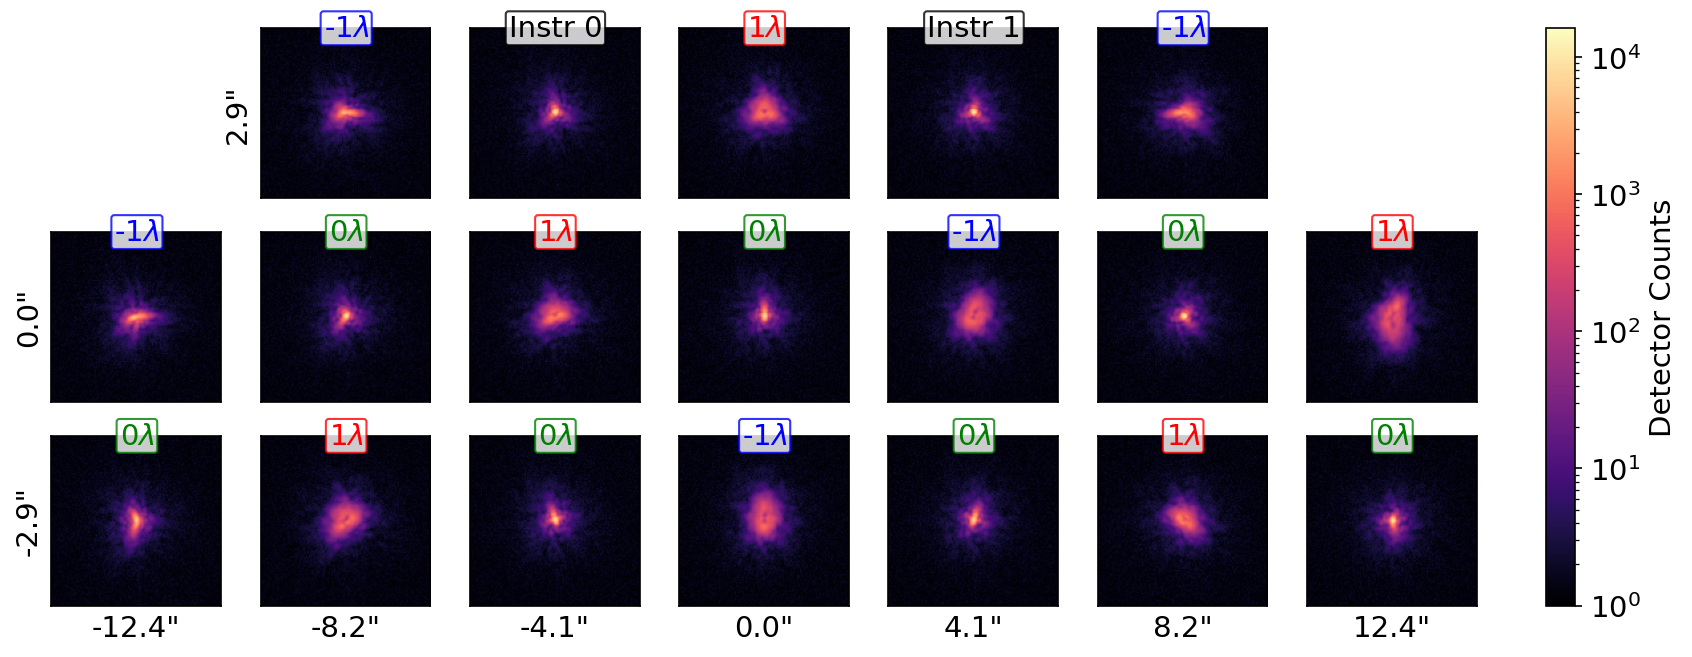

In [45]:
images = sys.snap(stacked_frames=30)

fig, axs = plt.subplots(ncols=7, nrows=3, figsize=(15, 5), dpi=150)
spec = plt.GridSpec(ncols=7, nrows=3)

count = 0
lol = 0
for i, ax in enumerate(axs.flat):
    if  i == 0 or i == 6:
        ax.axis('off')
    else:
        im = ax.imshow(images[count].get(), cmap='magma', norm='log', vmax=sys.well_depth, vmin=1)
        ax.set_xticks([])
        ax.set_yticks([])

        if count in (0, 5, 12):
            ax.set_ylabel(f'{sys.src_pos[count][1] * 60:.01f}"', fontsize=14)
        
        if count >= 12:
            ax.set_xlabel(f'{sys.src_pos[count][0] * 60:.01f}"', fontsize=14)

        if defocuses[count] == -1:
            c = "blue"
        elif defocuses[count] == 0:
            c = "green"
        elif defocuses[count] == 1:
            c = "red"
        l = f'{defocuses[count]:.0f}$\lambda$'

        if count in (1, 3):
            c = "black"
            l = f"Instr {lol:.0f}"
            lol += 1

        ax.text(64, 138, l,
                color=c, fontsize=14,
                ha='center', va='top',
                bbox=dict(facecolor='white', edgecolor=c, alpha=0.8, pad=0.1, boxstyle='round'))
        
        count += 1


cb = plt.colorbar(im, ax=axs, fraction=0.14, pad=0.04, label='Detector Counts')
cb.set_label('Detector Counts', fontsize=14)
cb.ax.tick_params(labelsize=14)
fig.set_tight_layout = True


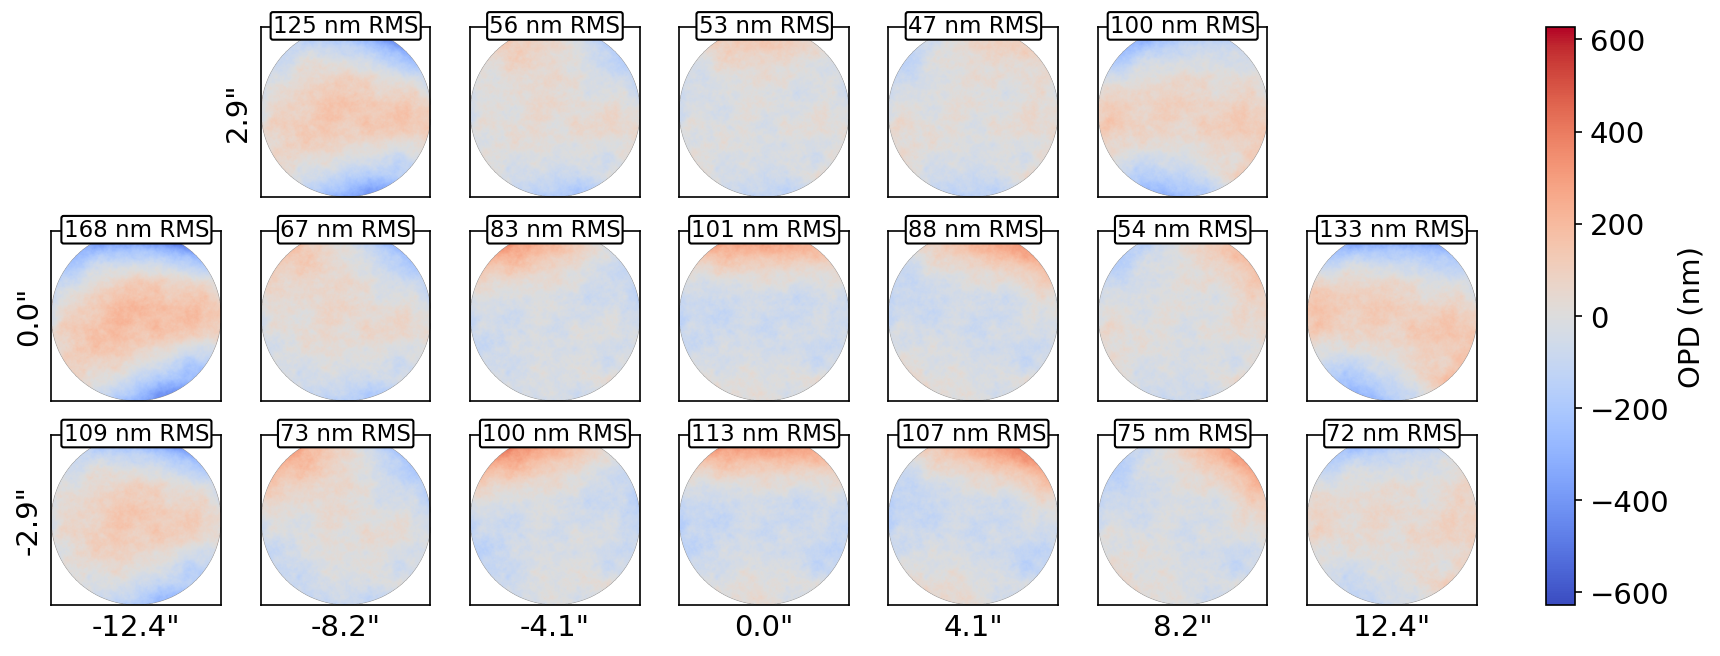

In [46]:
opds = sys.get_opds()['Field']

optic_opd = np.sum(np.array(sys.get_opds()['Optics']), axis=0) + sys.get_opds()['Bending']

rms_vals = []
for opd in opds:
    opd[~sys.pupil] = np.nan
    opd -= np.nanmean(opd)

v1 = np.nanmax(np.array(opds))
v2 = np.abs(np.nanmin(np.array(opds)))
v = np.max(np.array([v1, v2]))

opds = [opd + optic_opd for opd in opds]

for opd in opds:
    opd[~sys.pupil] = np.nan
    opd -= np.nanmean(opd)
    rms_vals.append(np.sqrt(np.nanmean(opd ** 2)))

fig, axs = plt.subplots(ncols=7, nrows=3, figsize=(15, 5), dpi=150)
spec = plt.GridSpec(ncols=7, nrows=3)

count = 0
for i, ax in enumerate(axs.flat):
    if  i == 0 or i == 6:
        ax.axis('off')
    else:
        im = ax.imshow(opds[count].get(), cmap='coolwarm', vmax=v, vmin=-v)
        ax.set_xticks([])
        ax.set_yticks([])

        if count in (0, 5, 12):
            ax.set_ylabel(f'{sys.src_pos[count][1] * 60:.01f}"', fontsize=14)
        
        if count >= 12:
            ax.set_xlabel(f'{sys.src_pos[count][0] * 60:.01f}"', fontsize=14)

        l = f'{rms_vals[count]:.0f} nm RMS'
        c = "black"

        ax.text(256, 550, l,
                color=c, fontsize=11,
                ha='center', va='top',
                bbox=dict(facecolor='white', edgecolor=c, alpha=1, pad=0.1, boxstyle='round'))
        
        count += 1


cb = plt.colorbar(im, ax=axs, fraction=0.14, pad=0.04)
cb.set_label('OPD (nm)', fontsize=14)
cb.ax.tick_params(labelsize=14)
fig.set_tight_layout = True

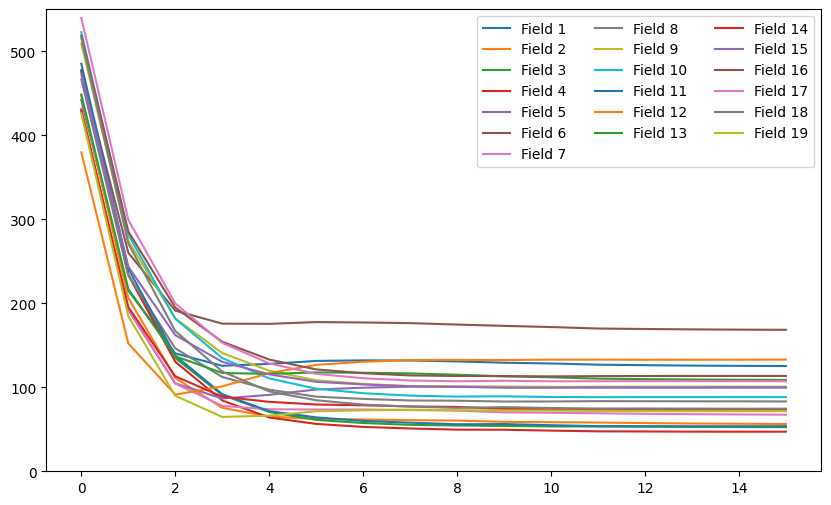

In [ ]:
rms_vals = np.array(alignment_rms)

plt.figure(figsize=(7, 5), dpi=150)
for i in range(rms_vals.shape[1]):
    plt.plot(rms_vals[:, i].get(), label='Field ' + str(i + 1))
plt.ylim([0, 550])
plt.legend(ncols=4)

# save data

In [49]:
fits.writeto('/home/derbyk/src/ffpr/data/alignment_ims.fits', data=np.asnumpy(alignment_ims), overwrite=True)
fits.writeto('/home/derbyk/src/ffpr/data/alignment_opds.fits', data=np.asnumpy(alignment_opds), overwrite=True)
fits.writeto('/home/derbyk/src/ffpr/data/alignment_rms.fits', data=np.asnumpy([[float(li) for li in lo] for lo in alignment_rms]), overwrite=True)

# load data

In [11]:
alignment_ims = fits.getdata('/home/derbyk/src/ffpr/data/alignment_ims.fits')
alignment_opds = fits.getdata('/home/derbyk/src/ffpr/data/alignment_opds.fits')
alignment_rms = fits.getdata('/home/derbyk/src/ffpr/data/alignment_rms.fits')

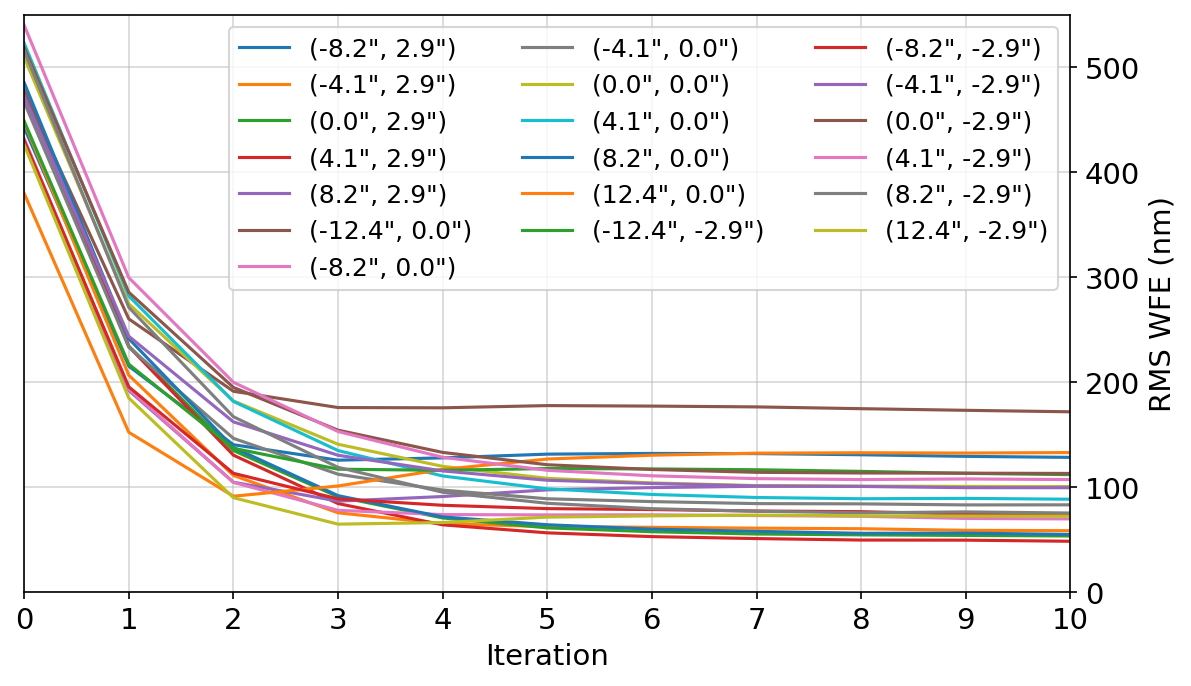

In [12]:
rms_vals = np.array(alignment_rms)


fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9, 5), dpi=150)
for i in range(rms_vals.shape[1]):
    ax.plot(rms_vals[:11, i].get(), label=f'({sys.src_pos[i][0] * 60:.1f}", {sys.src_pos[i][1] * 60:.1f}")')
ax.set_ylim([0, 550])
ax.set_xlim([0, 10])
ax.legend(ncols=3, fontsize=12)
ax.set_xlabel('Iteration', fontsize=14)
ax.set_ylabel('RMS WFE (nm)', fontsize=14, position="right")
ax.grid(alpha=0.5)
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
ax.set_yticks([0, 100, 200, 300, 400, 500])
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.tick_params(labelsize=14)

# debug

In [ ]:
opds_sys = sys.get_opds()
opds_truth = [np.array(opds_sys['Optics']).sum(axis=0) + opd_field for opd_field in opds_sys['Field']]

for i, (opt, opd_truth) in enumerate(zip(ff_opt.optlist, opds_truth)):

    opd_truth[~sys.pupil] = np.nan
    opd_truth -= np.nanmean(opd_truth)

    opd_est = opt.opd
    opd_est[~sys.pupil] = np.nan
    opd_est -= np.nanmean(opd_est)

    opd_diff = opd_truth - opd_est
    opd_diff -= np.nanmean(opd_diff)

    v1 = np.nanmax(opd_truth) # np.nanstd(opd_truth) * 3
    v2 = np.nanmax(opd_est) # np.nanstd(opd_est) * 3
    v3 = np.max(np.array([v1, v2]))

    psf_truth = opt.psf
    psf_est = opt.I

    fig = plt.figure(figsize=(15, 8))
    spec = plt.GridSpec(ncols=6, nrows=2)

    ax1 = fig.add_subplot(spec[0, :2])
    map = ax1.imshow(opd_truth.get() * sys.pupil.get(), vmin=-v3, vmax=v3, cmap='coolwarm')
    plt.colorbar(mappable=map, pad=0.04, fraction=0.046, label="OPD (nm)")
    ax1.set_title(f"Truth\nRMS: {np.sqrt(np.mean(opd_truth[sys.pupil.astype(bool)] ** 2)):0.1f} nm")
    ax1.set_xticks([]); ax1.set_yticks([])

    ax2 = fig.add_subplot(spec[0, 2:4])
    map = ax2.imshow(opd_est.get() * sys.pupil.get(), vmin=-v3, vmax=v3, cmap='coolwarm')
    plt.colorbar(mappable=map, pad=0.04, fraction=0.046, label="OPD (nm)")
    ax2.set_title(f"Estimate\nRMS: {np.sqrt(np.mean(opd_est[sys.pupil.astype(bool)] ** 2)):0.1f} nm")
    ax2.set_xticks([]); ax2.set_yticks([])

    ax3 = fig.add_subplot(spec[0, 4:])
    map = ax3.imshow(opd_diff.get() * sys.pupil.get(), vmin=-v3, vmax=v3, cmap='coolwarm')
    plt.colorbar(mappable=map, pad=0.04, fraction=0.046, label="OPD (nm)")
    ax3.set_title(f"Difference\nRMS: {np.sqrt(np.mean(opd_diff[sys.pupil.astype(bool)] ** 2)):0.1f} nm")
    ax3.set_xticks([]); ax3.set_yticks([])

    ax4 = fig.add_subplot(spec[1, :3])
    map = ax4.imshow(psf_truth.get() / psf_truth.max().get(), norm='log', vmin=1e-4, cmap='magma')
    plt.colorbar(mappable=map, pad=0.04, fraction=0.046, label='Log$_{10}$(NI)')
    ax4.set_title('Truth')
    ax4.set_xticks([]); ax4.set_yticks([])

    ax5 = fig.add_subplot(spec[1, 3:5])
    map = ax5.imshow(psf_est.get() / psf_est.max().get(), norm='log', vmin=1e-4, cmap='magma')
    plt.colorbar(mappable=map, pad=0.04, fraction=0.046, label='Log$_{10}$(NI)')
    ax5.set_title('Estimate')
    ax5.set_xticks([]); ax5.set_yticks([])